# 4. Thermal conductivity modeling of the Lennard-Jones fluid

This notebook is part of the Supporting Information of the article *Simulation and data-driven modeling of the transport properties of the Mie fluid* by Gustavo Chaparro and Erich A. Müller. (Submitted to Journal of Physical Chemistry B).

This work aims to compute and model the self diffusivity ($D^*$), shear viscosity ($\eta^*$), and thermal conductivity ($\kappa^*$) of systems of particles interacting through the Mie potential:

$$ \frac{\mathcal{U}^{Mie}}{\epsilon} = \underbrace{\left[ \frac{\lambda_r}{\lambda_r- \lambda_a} \left( \frac{\lambda_r}{\lambda_a}\right)^{\frac{\lambda_a}{\lambda_r - \lambda_a}}   \right]}_{\mathcal{C}^{Mie}} \left[ \left(\frac{\sigma}{r}\right)^{\lambda_r} -  \left(\frac{\sigma}{r}\right)^{\lambda_a} \right] $$ 

Here, $\mathcal{U}^{Mie}$ is the interaction energy between two particles, $\epsilon$ is the interaction energy well depth, $\sigma$ is the length scale, loosely associated to the effective particle diameter, and $r$ is the center-to-center distance between two Mie particles. Finally, $\lambda_r$ and $\lambda_a$ are the repulsive and attractive exponents, respectively. This work uses reduced units in which the Boltzmann constant ($k_b$), potential well depth ($\epsilon$), the shape parameter ($\sigma$), and Mie particle mass ($M$) are set to unity.

This notebook shows how to use the trained ANN models for the thermal conductivity of the the Mie Fluid. This notebook relies on the following packages:
- Numpy (tested on version 1.24.2)
- jax (tested on version 0.4.4)
- flax (tested on version 0.6.6)
- nest_asyncio
- tp_modeling (Package containing the Transport Properties and Helmholtz models based on ANN using JAX and Flax)
- matplotlib (tested on version 3.6.3)
- pandas (tested on version 1.5.3)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tp_modeling import helper_get_alpha # helper function to get alpha_vdw value of a Mie Fluid
from tp_modeling import TransportModel_PVT # Transport model for the Mie Fluid (TP = ANN(alpha, rho, T))
from tp_modeling import TransportModel_PVT_Tinv # Transport model for the Mie Fluid (TP = ANN(alpha, rho, 1/T))
from tp_modeling import TransportModel_entropy # Transport model for the Mie Fluid  based on entropy scaling (TP = ANN(alpha, S^res))
from tp_modeling import TransportModelResidual_PVT_Tinv # Transport model for the Mie Fluid (TP = TP[1] + [ANN(alpha, rho, 1/T) -  ANN(alpha, rho=0., 1/T)])
from tp_modeling import thermal_conductivity_mie6_dilute # dilute gas approximations for diffusivity, viscosity and thermal conductivity
from tp_modeling import linear_activation

# some JAX/FLax imports
from jax import numpy as jnp
from jax.config import config
from flax.training import checkpoints
from flax.core import freeze
from flax import linen as nn
import nest_asyncio
nest_asyncio.apply()

# seeting up the precission to float64
PRECISSION = 'float64'
if PRECISSION == 'float64':
    config.update("jax_enable_x64", True)
    type_np = np.float64
    type_jax = jnp.float64
else:
    config.update("jax_enable_x32", True)
    type_np = np.float32
    type_jax = jnp.float32

The database is loaded as follows:

In [2]:
# Reading the thermal conductivity database
path_to_data = '../databases/miefluid-tcond.csv'
df_tcond = pd.read_csv(path_to_data)
df_tcond.head()

,lr,la,rho*,T*,rho*_sim,T*_sim,P*_sim,TotEn_sim,thermal_conductivity,T*_sim_std,P*_sim_std,TotEn_sim_std,thermal_conductivity_std
0,7.0,6.0,0.04,1.6,0.04,1.599728,0.052498,1.922185,1.158727,0.004463,0.000250,0.000057,0.058083
1,7.0,6.0,0.05,1.3,0.05,1.299800,0.044186,1.258454,0.633566,0.008292,0.000382,0.000141,0.037655
2,7.0,6.0,0.05,1.8,0.05,1.800123,0.073516,2.131654,0.766830,0.004548,0.000365,0.000064,0.007739
3,7.0,6.0,0.05,1.9,0.05,1.899829,0.079119,2.293077,0.766218,0.004264,0.000372,0.000061,0.060137
4,7.0,6.0,0.05,2.0,0.05,1.999876,0.084677,2.452661,0.887093,0.004325,0.000368,0.000058,0.000405


The model for the shear viscosity is loaded as follows:

In [3]:
##########################################
# LOADING THE THERMAL CONDUCTIVITY MODEL #
##########################################

# Folder where the model are stored
save_dir = '../models/thermal-conductivity/'
# Name of the model
model_name = "logtcond-rho-Tinv"
prefix_tp = f'{model_name}-params'
step = None
# Loading the model
state_restored = checkpoints.restore_checkpoint(save_dir, target=None, prefix=prefix_tp)
tp_activation = state_restored['activation']
tp_features = list(state_restored['features'].values())

# Infering the model type
if 'residual' in model_name:
    TPModel = TransportModelResidual_PVT_Tinv
elif 'Tinv' in model_name:
    TPModel = TransportModel_PVT_Tinv
elif 'entropy' in model_name:
    TPModel = TransportModel_entropy
else:
    TPModel = TransportModel_PVT

# Getting the output activation function
if tp_activation == 'linear':
    output_activation = linear_activation
elif tp_activation == 'softplus':
    output_activation = nn.softplus

# ANN model
tcond_model = TPModel(features=tp_features, output_activation=output_activation)
# ANN parameters
tcond_params = freeze({'params': state_restored['params']})

Now that the database and thermal conductivity models are available, the data and the model can be compared. In this notebook, we will exemplify the results for the Lennard-Jones fluid ($\lambda_r=12$ and $\lambda_a=6$). First, we set up the exponents to variables and compute the $\alpha_{vdw}$ parameter. 

$$\alpha_{vdw} =  \mathcal{C}^{Mie} \left[ \frac{1}{\lambda_a - 3} - \frac{1}{\lambda_r - 3}\right]$$

The `helper_get_alpha` function computes this parameter.

In [4]:
# setting up the exponets of the Lennard-Jones fluid
lambda_r = 12
lambda_a = 6
# getting the alpha_vdw value
alpha_aux = helper_get_alpha(lambda_r, lambda_a)


The database can also be filtered just to have the data of the Lennard-Jones fluid.

In [5]:
# filtering the database to get only the Lennard-Jones fluid result.
filter_lr = df_tcond['lr'] == lambda_r
filter_la = df_tcond['la'] == lambda_a
df_lr12 = df_tcond[filter_lr & filter_la].copy().reset_index(drop=True)
df_lr12.head()

,lr,la,rho*,T*,rho*_sim,T*_sim,P*_sim,TotEn_sim,thermal_conductivity,T*_sim_std,P*_sim_std,TotEn_sim_std,thermal_conductivity_std
0,12.0,6.0,0.03,8.72,0.03,8.720791,0.269107,12.959900,2.299670,0.002828,0.000570,0.000004,0.022092
1,12.0,6.0,0.04,7.45,0.04,7.449588,0.308620,10.999999,1.837500,0.002915,0.000784,0.000012,0.195045
2,12.0,6.0,0.04,10.00,0.04,10.001297,0.416423,14.855384,2.403282,0.003572,0.000982,0.000037,0.074681
3,12.0,6.0,0.05,1.10,0.05,1.099761,0.043296,1.207618,0.590839,0.004345,0.000347,0.000020,0.019372
4,12.0,6.0,0.05,1.90,0.05,1.899855,0.088691,2.508971,0.818198,0.002985,0.000435,0.000014,0.065613


Now, we will use the `tcond_model.apply` method to obtain the predicted $\ln(\kappa^*)$ by the ANN model. This function requires the arrays $\alpha_{vdw}$, $\rho^*$, and $T^*$. In this example, we will compute the results for five different isotherms.

In [6]:
# setting up the temperatures to plot
T1 = 0.9
T2 = 1.0
T3 = 1.3
T4 = 2.8
T5 = 6.0

# setting up the arrays to compute the transport property
n = 100
rho_plot = np.linspace(0.0, 1.2, n)
alpha_plot = np.ones(n) * alpha_aux
T1_plot = np.ones(n) * T1
T2_plot = np.ones(n) * T2
T3_plot = np.ones(n) * T3
T4_plot = np.ones(n) * T4
T5_plot = np.ones(n) * T5

# computing the thermal conductivity
# remember this models gives you ln(tcond)
lntcond_T1_model = tcond_model.apply(tcond_params, alpha_plot, rho_plot, T1_plot) 
lntcond_T2_model = tcond_model.apply(tcond_params, alpha_plot, rho_plot, T2_plot) 
lntcond_T3_model = tcond_model.apply(tcond_params, alpha_plot, rho_plot, T3_plot) 
lntcond_T4_model = tcond_model.apply(tcond_params, alpha_plot, rho_plot, T4_plot) 
lntcond_T5_model = tcond_model.apply(tcond_params, alpha_plot, rho_plot, T5_plot) 

2023-12-14 10:22:48.393302: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


The results can be plotted and compared against the molecular dynamics results.

Text(0.5, 1.0, 'Thermal conductivity of Mie fluid: $\\lambda_r$ = 12, $\\lambda_a$ = 6')

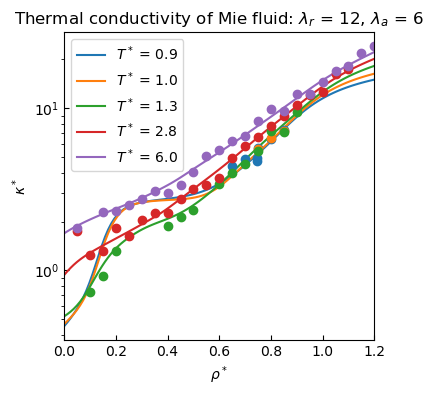

In [7]:
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(111)

# plotting the self diffusivity results from the ANN model
ax1.plot(rho_plot, np.exp(lntcond_T1_model), label=f'$T^*$ = {T1}', color='C0')
ax1.plot(rho_plot, np.exp(lntcond_T2_model), label=f'$T^*$ = {T2}', color='C1')
ax1.plot(rho_plot, np.exp(lntcond_T3_model), label=f'$T^*$ = {T3}', color='C2')
ax1.plot(rho_plot, np.exp(lntcond_T4_model), label=f'$T^*$ = {T4}', color='C3')
ax1.plot(rho_plot, np.exp(lntcond_T5_model), label=f'$T^*$ = {T5}', color='C4')

filter_T1 = df_lr12['T*'] == T1
filter_T2 = df_lr12['T*'] == T2
filter_T3 = df_lr12['T*'] == T3
filter_T4 = df_lr12['T*'] == T4
filter_T5 = df_lr12['T*'] == T5

# plotting the shear viscosity results from the database
ax1.plot(df_lr12[filter_T1]['rho*'], df_lr12[filter_T1]['thermal_conductivity'], 'o', color='C0')
ax1.plot(df_lr12[filter_T2]['rho*'], df_lr12[filter_T2]['thermal_conductivity'], 'o', color='C1')
ax1.plot(df_lr12[filter_T3]['rho*'], df_lr12[filter_T3]['thermal_conductivity'], 'o', color='C2')
ax1.plot(df_lr12[filter_T4]['rho*'], df_lr12[filter_T4]['thermal_conductivity'], 'o', color='C3')
ax1.plot(df_lr12[filter_T5]['rho*'], df_lr12[filter_T5]['thermal_conductivity'], 'o', color='C4')

ax1.legend()
ax1.set_yscale('log')
ax1.set_xlim([0.0, 1.2])
# ax1.set_ylim([0.0, 0.8])
ax1.tick_params(direction='in')
ax1.set_xlabel(r'$\rho^*$')
ax1.set_ylabel(r'$\kappa^*$')
ax1.set_title(f'Thermal conductivity of Mie fluid: $\lambda_r$ = {lambda_r}, $\lambda_a$ = {lambda_a}')